# Nonlinear Independent Components Estimation (NICE) for Time Series Generation

On this notebook, we’ll get hands-on with using a **NICE** model to tackle a generation task. Along the way, you’ll see how the model is built and trained on a specific dataset, and pick up the key ideas so that you can apply them to your own projects with your own data

## Import Libraries

This notebook relies on a set of libraries for time series forecasting and analysis. These include:

- **Pandas / NumPy** for tabular and numerical operations  
- **Hugging Face Datasets** for loading benchmark datasets  
- **Custom `genai4t` utilities** developed for this book to streamline preprocessing, training, and evaluation  
- **Matplotlib** for visualization  

We organize the imports below for clarity.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
import random
import pandas as pd
from lightning import seed_everything
import torch
from datasets import load_dataset
from genai4t.utils import set_random_state, get_torch_device
from genai4t.data.processing import (
    split_timeseries_with_length,
    dataset_to_pandas
)
from sklearn.model_selection import train_test_split
from genai4t.plot_style import plot_style

## Experiment Configuration

To keep our experiments organized, we define all key parameters (e.g., model hyperparameters, dataset settings, training options) as configuration dictionaries

This allows us to:
- Easily adjust settings in one place
- Avoid hardcoding values throughout the notebook

In [2]:
ENV_CONFIG = {
        'random_state': 2024,
        'use_cuda': True
    }

DATA_CONFIG = {
        'name':  "gatam4t/genai4t_spx_generation",
        'batch_size': 16,
        'sequence_len': 20,
        "num_eval_iterations": 50,
    }

In [3]:
set_random_state(ENV_CONFIG["random_state"])
device = get_torch_device()

Seed set to 2024


## Load Data

In this experiment, we use time series data derived from the **S&P 500 Index (SPX)**, a benchmark index that tracks the performance of 500 of the largest publicly traded companies in the United States. Specifically, the dataset contains two time series:

•⁠  ⁠The log return of the closing price
•⁠  ⁠The log of the Median Realized Volatility

These values span the period from 2005-01-01 to 2020-06-01, and have been standardized to have a mean of 0 and a standard deviation of 1.

The data originates from the [Oxford-Man Realized Volatility Indices dataset](https://github.com/onnokleen/mfGARCH/raw/v0.1.9/data-raw/OxfordManRealizedVolatilityIndices.zip), published by the Oxford-Man Institute of Quantitative Finance (University of Oxford) in collaboration with Man Group, a global active investment management firm. This dataset is widely used in academic research and provides daily realized volatility measures computed from high-frequency intraday financial data.

To make access easier and ensure long-term reproducibility, a copy of the dataset processed has been published in the Hugging Face repo associated with this book. We'll load it directly from there.

While we use this dataset for generation notebooks, the methods in this notebook work with any dataset in wide time series format (i.e., one time series per column) with minimal adjustments.

In [4]:
dataset = load_dataset(DATA_CONFIG["name"], split='train')

# Convert to pandas DataFrame and enforce consistent time frequency
data = dataset_to_pandas(dataset)

# Display the first few rows of the DataFrame
data.head()

,logreturn,logvol
0,-0.979992,0.212416
1,-0.335923,0.438473
2,0.244094,-0.069770
3,-0.132698,0.087008
4,0.257988,-0.278999


In [5]:
# the data have been standardized
data.describe().T

,count,mean,std,min,25%,50%,75%,max
logreturn,3394.0,-3.371860e-09,1.0,-8.298640,-0.356489,0.033435,0.429621,9.072744
logvol,3394.0,-5.934473e-07,1.0,-2.290916,-0.676626,-0.136567,0.602935,4.178672


In [6]:
# transform dataframe into a numpy array
data_as_array = data.to_numpy().astype(np.float32)

In [7]:
data_as_array

array([[-0.979992  ,  0.21241626],
       [-0.33592334,  0.43847257],
       [ 0.24409448, -0.06976987],
       ...,
       [-1.195638  ,  1.0179971 ],
       [ 0.1652753 ,  0.08472553],
       [-0.74991983,  0.80158144]], dtype=float32)

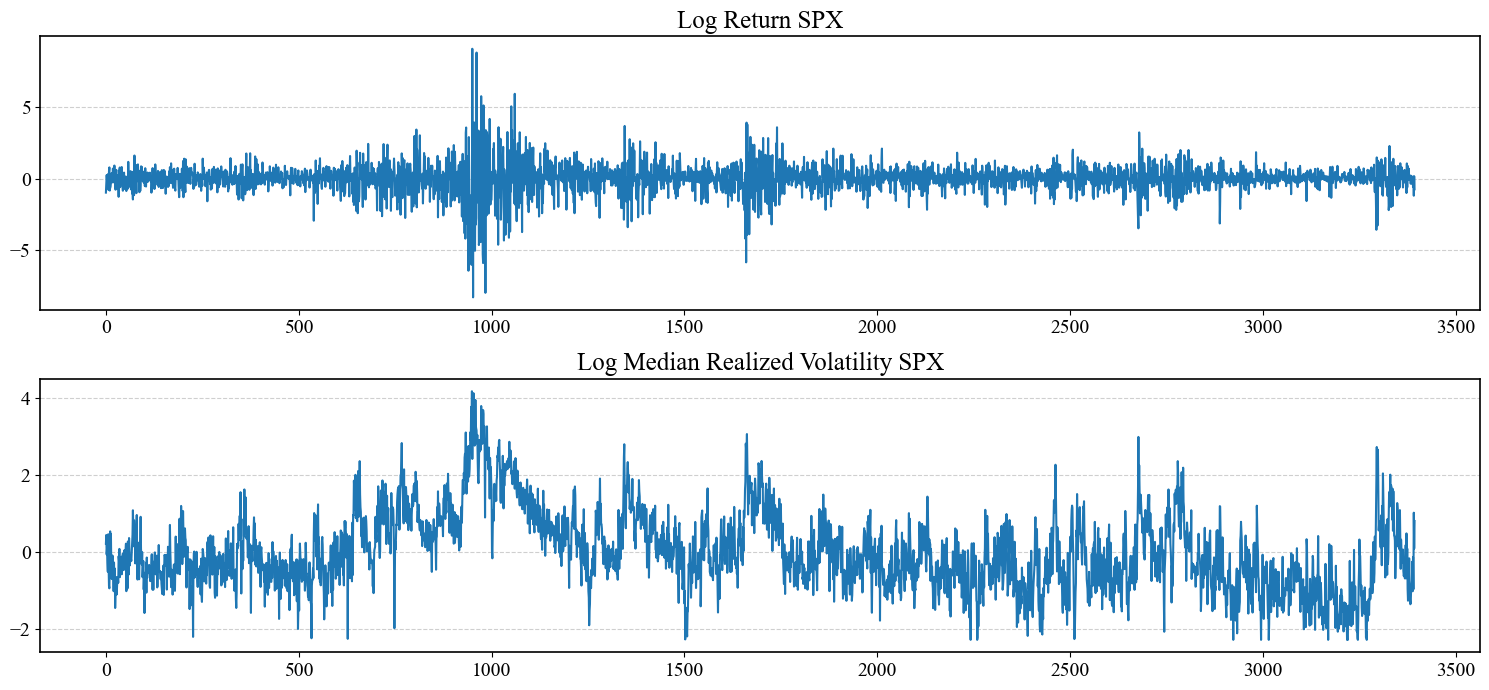

In [8]:
f, axs = plt.subplots(2, 1, figsize=(15, 7))
axs[0].plot(data_as_array[:, 0])
axs[0].set_title("Log Return SPX")
plot_style.apply_plot_style(axs[0])
plot_style.apply_grid(axs[0])
axs[1].plot(data_as_array[:, 1])
axs[1].set_title("Log Median Realized Volatility SPX")
plot_style.apply_plot_style(axs[1])
plot_style.apply_grid(axs[1])

## Sequence Generation

Our models will generate new time series of fixed length `sequence_len`, so we need to transform our historical data into this format. We accomplish this by using the `split_timeseries_with_length` function.

In [9]:
# creates sequence
sequences = split_timeseries_with_length(data_as_array, DATA_CONFIG["sequence_len"])

In [10]:
sequences.shape

(3375, 20, 2)

In [11]:
_, seq_len, feat_dim = sequences.shape 

In [12]:
seq_len

20

In [13]:
feat_dim

2

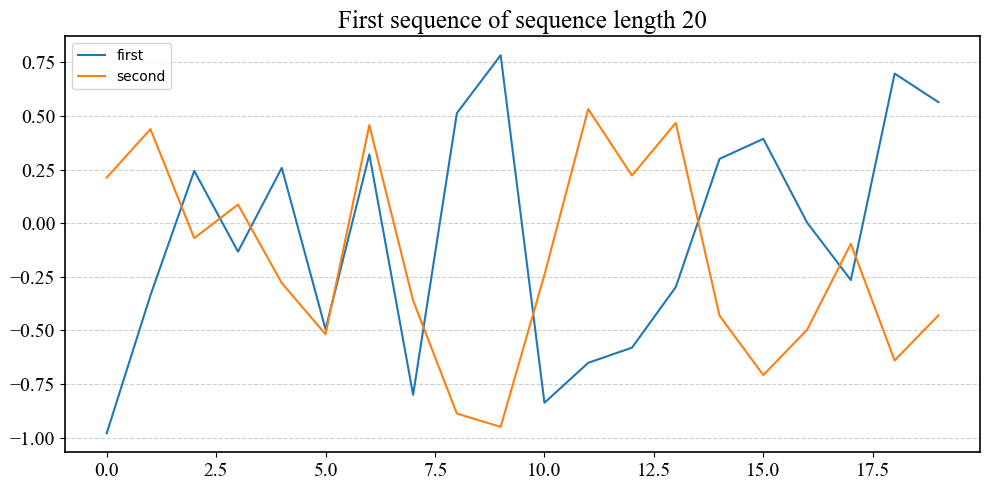

In [14]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(sequences[0, :, 0], label='first')
ax.plot(sequences[0, :, 1], label='second')
plot_style.apply_grid(ax)
ax.set_title(f"First sequence of sequence length {seq_len}")
plot_style.apply_plot_style(ax)
ax.legend()
plt.show()

## Split the Dataset into Train/Test
We split the sequences into training and testing sets, with 20% of the data reserved for testing. To ensure reproducibility, we use the `random_state=ENV_CONFIG["random_state"]` parameter.

In [15]:
train_data, test_data = train_test_split(
    sequences,
    test_size=0.2,
    random_state=ENV_CONFIG["random_state"])

In [16]:
train_data.shape

(2700, 20, 2)

In [17]:
test_data.shape

(675, 20, 2)

## Setting Up the Training Dataloader

We will create a DataLoader using PyTorch's built-in implementation to handle batching.

In [18]:
from torch.utils.data import DataLoader

In [19]:
train_dl = DataLoader(train_data, batch_size=DATA_CONFIG["batch_size"], shuffle=True)

In [20]:
# Number of batches
len(train_dl)

169

In [21]:
# Fetch a single batch from the DataLoader
batch = next(iter(train_dl))
# batch size time series of length sequence_len!
batch.shape

torch.Size([16, 20, 2])

## Introduction to Flow Models

In this notebook, we explore **flow models** for modeling complex probability distributions: These models allow us to compute exact probability densities, generate samples efficiently, and perform representation learning. All of this without relying on likelihood approximations like those required in VAEs (See Chapter 6). Flow models belong to the class of explicit models with tractable densities.

In a few words, a flow models consist of:
- A **base distribution** $p(x)$, typically a standard normal.
- A **deterministic function** $x= f(x)$, called the flow.

When the base distribution $p(z)$ is a standard normal, the flow model is called a **normalizing flow**.

Using the change of variables formula, the density of $x$ is given by:

$$
p_{x}(x) = p_{z}(z)
\left|
\det
\left(
\frac{\partial f(z)}{\partial z}
\right)
\right|^{-1}
$$


where $z = f^{-1}(x)$, and the Jacobian matrix $\frac{\partial f(z)}{\partial z}$ must be invertible.

To satisfy this requirement, the flow $f$ must be:
- Invertible,
- Differentiable, and
- Of the same dimensionality as $x$.

A common strategy for designing expressive flows is through function composition. If we define $f = f_K \circ \dots \circ f_1 $, where each $f_k$ is invertible and differentiable, then the full flow remains invertible and differentiable. 


Something you'll notice as you read more papers and explore implementations of flow models is the following. While flow models are often described for  understanding purposes as a mapping from the latent space to the data space, approach we follow in the book, where $x = f(z)$, most practical implementations define $f$ in the opposite direction: from data space to latent space, for example,  $z = f(x)$. This direction is convenient for computing log-likelihoods during training.  For this reason, in this notebook we follow the convention used in most implementations.

For more details, refer to Chapter 7 of the book.

## Coupling Layer (or Coupling Flow)

One effective way to design complex non-linear flow is based on **coupling layers**. Couping layers allow efficient computation of both the flow and the determinant of the Jacobian.


Coupling layers work by partitioning the latent vector $z$ into two parts, denoted as:  
$$
z = [z_{1:D'} \, , \, z_{D'+1:D}]^T
$$

where $D$ is the dimensionality of the vector  $z$. Due to the constraints of invertibility, the dimensionality of $x$ must match that of $z$, so we similarly split $x$ into:  
$$
x = [x_{1:D'} \, , \, x_{D'+1:D}]^T
$$

Each coupling flow (one of potentially many compositions) is defined as:

$$
\begin{split}
x_{1:D'} &= z_{1:D'} \\
x_{D'+1:D} &= \mu_{\theta}(z_{1:D'}) + \sigma_{\theta}(z_{1:D'}) \odot z_{D'+1:D}
\end{split}
$$

Here:
- $\mu_\theta$ and $\sigma_\theta$ are neural networks,
- $\odot$ denotes element-wise product,
- $\mu_\theta$ acts like a bias term,
- $\sigma_\theta$ serves as a scaling term.

This structure makes sure that the transformation is **invertible** and **differentiable**, while allowing complex transformations of the input.


In this notebook, we will implement a type of coupling-based model known as **Nonlinear Independent Components Estimation (NICE)**.

## NICE

[NICE](https://arxiv.org/abs/1410.8516) by Dinh et al. (2015), is a specific instance of a coupling flow, where the scaling term $\sigma_\theta$ is fixed to 1. This simplifies the transformation to:

$$
\begin{split}
\mathbf{x}_{1:D'} &= \mathbf{z}_{1:D'} \\
\mathbf{x}_{D'+1:D} &= \mu_{\theta}(\mathbf{z}_{1:D'}) + \mathbf{z}_{D'+1:D}
\end{split}
$$


This design implies that the determinant of the Jacobian is equal to 1, which simplifies the log-likelihood used for training:

$$
\mathcal{L} = \sum_{n} \log p_{z}(f(x_n))
$$



You can find more on this in Chapter 7 of the book, and even more details in the original [NICE](https://arxiv.org/abs/1410.8516) paper.

### Masks

In practice, there are many ways to partition the vector $z$ into two parts. Some implementations use what is called a mask to decide which elements of the vector will go into the first or second partition.

In this tutorial, we use a checkerboard mask. A checkerboard mask is a binary vector $ \mathbf{m} $ of the same dimension as $ z $, where each element is either 0 or 1. If the $ i $-th element of the mask is 1, for example,  $ m[i] = 1 $, then the corresponding coordinate $ z[i] $ is assigned to the first partition $ z_{1:D'} $; otherwise, it is assigned to the second partition $ z_{D'+1:D} $.

An important practical detail is that the mask alternates between successive flow layers, allowing each dimension of $z$ to be transformed over multiple layers. This makes the model able to learn more complex data transformations.


This notebook is inspired by [Normalizing Flows for image modeling Tutorial](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html)

### NICE Coupling Layer Example
Let's walk through a simple illustrating how `NICE` coupling layers are implemented. We'll explore how they transform data and how to compute their inverse.

In [22]:
set_random_state(ENV_CONFIG['random_state'])

Seed set to 2024


In [23]:
# lets create a random time series
z = np.random.randn(16)

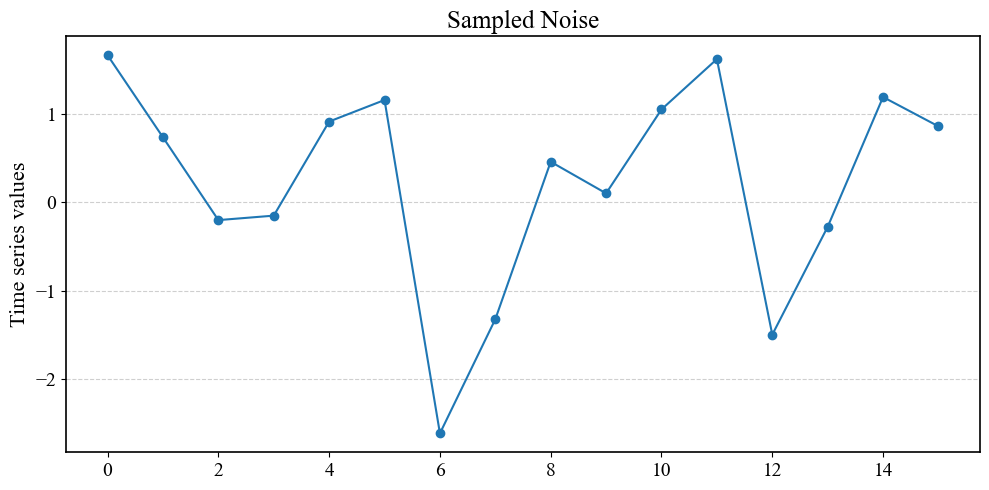

In [24]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(z, marker='o')
ax.set_ylabel("Time series values")
ax.set_title("Sampled Noise")
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)
plt.show()

In [25]:
# let's create the checkboard_mask, which alternates alternates between 1 and 0 at each position
checkboard_mask = np.arange(len(z)) % 2

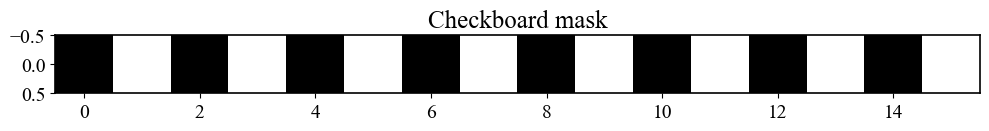

In [26]:
# Plotting the checkerboard mask
f, ax = plt.subplots(figsize=(10, 5))
ax.imshow([checkboard_mask], cmap="gray")
ax.set_title("Checkboard mask")
plot_style.apply_plot_style(ax)
plt.show()

In [27]:
z_input = z * (checkboard_mask)

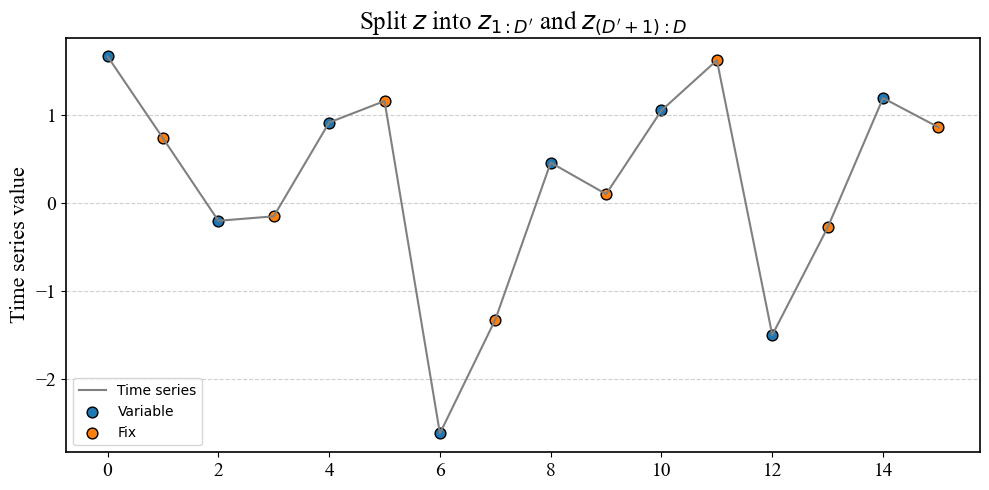

In [28]:
mask_colors = ['#1f77b4', '#ff7f0e'] 
color_labels = ['Variable', 'Fix']
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(z, color='gray', linewidth=1.5, label='Time series')
for val in [0, 1]:
    indices = np.where(checkboard_mask == val)[0]
    ax.scatter(indices, z[indices], color=mask_colors[val], label=color_labels[val], s=60, edgecolors='k')
ax.set_title("Split $z$ into $z_{1:D'}$ and $z_{(D'+1):D}$")
ax.set_ylabel('Time series value')
ax.legend()
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)
plt.show()

In [29]:
# let's compute the shift mu parameter
Wb = np.random.randn(len(z), len(z))

In [30]:
bias = z_input @ Wb

In [31]:
output_mask = 1 - checkboard_mask

In [32]:
# we only modify where the mask is equal to 0
z_output = z + bias * output_mask

In [33]:
# compute the inverse

In [34]:
inverse_bias = (z_output * checkboard_mask) @ Wb

In [35]:
assert np.allclose(inverse_bias, bias)

In [36]:
z_inverse = z_output - output_mask * inverse_bias

In [37]:
z_inverse

array([ 1.66804732,  0.73734773, -0.20153776, -0.15091195,  0.91605181,
        1.16032964, -2.619962  , -1.32529457,  0.45998862,  0.10205165,
        1.05355278,  1.62404261, -1.50063502, -0.27783169,  1.19399502,
        0.86181533])

In [38]:
z

array([ 1.66804732,  0.73734773, -0.20153776, -0.15091195,  0.91605181,
        1.16032964, -2.619962  , -1.32529457,  0.45998862,  0.10205165,
        1.05355278,  1.62404261, -1.50063502, -0.27783169,  1.19399502,
        0.86181533])

In [39]:
assert np.allclose(z, z_inverse)

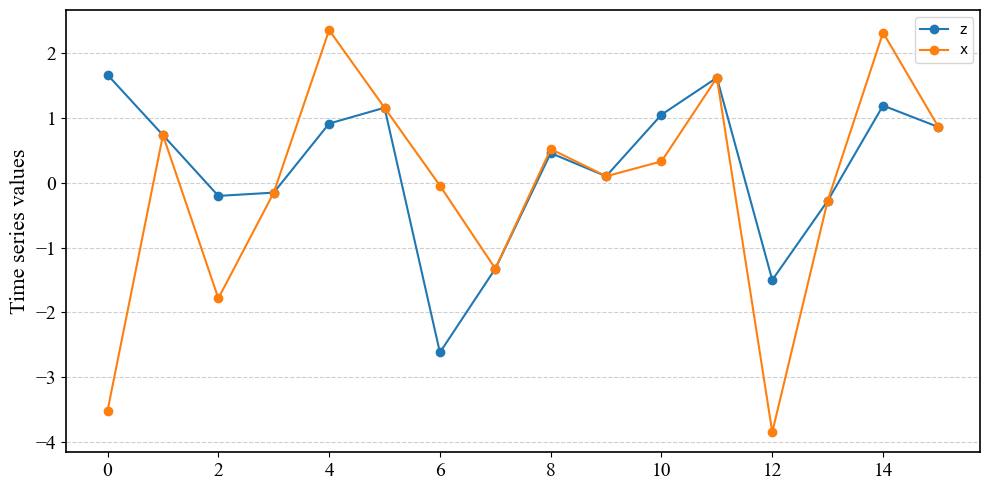

In [40]:
f, ax = plt.subplots(figsize=(10, 5))
ax.plot(z, marker='o', label="z")
ax.plot(z_output, marker='o', label="x")
ax.set_ylabel("Time series values")
plt.legend()
plot_style.apply_plot_style(ax)
plot_style.apply_grid(ax)
plt.show()

### Flow model implementation

Now let’s implement a general-purpose time series flow model. We'll define a `TimeSeriesFlowModel` that takes a list of invertible flow transformations (`flows`).

In [41]:
import numpy as np
import torch
from torch import nn
from typing import Tuple, List
from genai4t.model import BaseLightningModule

def create_checkboard_mask(seq_len: int, invert: bool = False) -> torch.Tensor:
    """
    Creates a checkerboard pattern mask for alternating transformations in normalizing flows.
    
    Args:
        seq_len (int): Length of the sequence to create the mask for
        invert (bool, optional): If True, inverts the checkerboard pattern. Defaults to False.
        
    Returns:
        torch.Tensor: A binary mask tensor of shape (1, seq_len, 1) with alternating 0s and 1s
    """
    indices = torch.arange(seq_len)
    mask = torch.fmod(indices, 2).to(torch.float32).view(1, seq_len, 1)
    if invert:
        mask = 1. - mask
    return mask


class TimeSeriesFlowModel(BaseLightningModule):
    """
    A normalizing flow model for time series data.
    
    This model implements a series of invertible transformations (flows) that can be used
    to transform time series data into a simpler distribution (typically Gaussian) and back.
    The model is trained using maximum likelihood estimation.
    
    Attributes:
        flows (nn.ModuleList): List of flow transformations to apply
        prior (torch.distributions.Normal): Prior distribution for the latent space
    """
    
    def __init__(self,
                 flows: List[nn.Module],
                 lr: float = 1e-3,
                 weight_decay: float = 0.):
        super().__init__(
            lr=lr,
            weight_decay=weight_decay)
        self.flows = nn.ModuleList(flows)
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)

    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Encodes input data into the latent space.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, feature_dim)
            
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: 
                - z: Latent representation
                - ldj: Log determinant of the Jacobian
        """
        z = x
        ldj = torch.zeros(x.shape[0], dtype=torch.float32).to(x.device)
        
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, x: torch.Tensor, return_ll: bool = False) -> torch.Tensor:
        """
        Computes the negative log-likelihood or log-likelihood of the input data.
        
        Args:
            x (torch.Tensor): Input tensor
            return_ll (bool, optional): If True, returns log-likelihood instead of bits per dimension.
                                      Defaults to False.
            
        Returns:
            torch.Tensor: Either bits per dimension (if return_ll=False) or log-likelihood (if return_ll=True)
        """
        z, ldj = self.encode(x)
        
        log_pz = self.prior.log_prob(z).sum(dim=[1, 2])
        log_px = ldj + log_pz
        
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(x.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(
        self,
        shape: List[int],
        device: torch.device,
        z_init: torch.Tensor = None) -> torch.Tensor:
        """
        Generates samples from the model by sampling from the prior and applying inverse flow transformations.
        
        Args:
            shape (List[int]): Desired shape of the samples [batch_size, seq_len, feature_dim]
            device (torch.device): Device to place the samples on
            z_init (torch.Tensor, optional): Initial latent representation to transform.
                                           If None, samples from the prior. Defaults to None.
            
        Returns:
            torch.Tensor: Generated samples of the specified shape
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=shape).to(device)
        else:
            z = z_init.to(device)
        # Transform z to x by inverting the flows
        ldj = torch.zeros(z.shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def step(self, batch):
        """
        Performs a single training step.
        
        Args:
            batch: Input batch of data
            
        Returns:
            torch.Tensor: Training loss (bits per dimension)
        """
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch)
        return loss


class MLPLayer(nn.Module):
    """
    A simple MLP layer for processing time series data.
    
    This layer applies a two-layer MLP to the flattened time series data and then
    reshapes it back to the original dimensions.
    """
    
    def __init__(self, seq_len: int, feat_dim: int):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(seq_len * feat_dim, seq_len * feat_dim),
            nn.ReLU(),
            nn.Linear(seq_len * feat_dim, seq_len * feat_dim)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the MLP layer.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, seq_len, feat_dim)
            
        Returns:
            torch.Tensor: Processed tensor of the same shape as input
        """
        bs, seq_len, feat_dim = x.shape
        x = x.view(bs, -1)
        x = self.layer(x)
        x = x.view(bs, seq_len, feat_dim)
        return x


### Define Nice Coupling Layer

Finally, let's define the `NiceCouplingLayer` layer.

In [42]:
import torch
from torch import nn
from typing import Tuple
from genai4t.chapters.flows.core import MLPLayer, create_checkboard_mask

class NiceCouplingLayer(nn.Module):
    """
    A coupling layer implementation following the NICE (Non-linear Independent Components Estimation) framework.
    
    This layer implements a bijective transformation that splits the input into two parts and applies
    an affine transformation to one part based on the other. The transformation is designed to be
    easily invertible while allowing for complex non-linear transformations.
    
    Args:
        network (nn.Module): A neural network that computes the transformation parameters
        mask (torch.Tensor): A binary mask that splits the input into two parts
        feat_dim (int): The dimension of the feature space
    """
    def __init__(
        self,
        network: nn.Module,
        mask: torch.Tensor,
        feat_dim: int,
    ):
        super().__init__()
        self.network = network
        self.register_buffer('mask', mask)
        self.scaling_factor = nn.Parameter(torch.zeros(feat_dim))

    def forward(
        self,
        z: torch.Tensor,
        ldj: torch.Tensor,
        reverse: bool = False) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass through the coupling layer.
        
        Args:
            z (torch.Tensor): Input tensor to transform
            ldj (torch.Tensor): Log determinant of the Jacobian
            reverse (bool): If True, performs the inverse transformation
            
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Transformed tensor and updated log determinant
        """
        # compute scale and bias based a section of the input
        z_input = self.mask * z
        bias = self.network(z_input)
        
        output_mask = 1 - self.mask
        bias = bias * output_mask
        
        if not reverse:
            # shift first and then slace, it is a design choice and have no impact on the output
            z_output = z + bias
            ldj += 0
            return z_output, ldj
        else:
            z_inverse = z - bias
            ldj -= 0
            return z_inverse, ldj
        

def create_nice_layer(seq_len: int, feat_dim: int, invert: bool) -> NiceCouplingLayer:
    """
    Creates a NICE coupling layer with a checkerboard mask pattern.
    
    Args:
        seq_len (int): Length of the sequence
        feat_dim (int): Dimension of the feature space
        invert (bool): Whether to invert the checkerboard mask pattern
        
    Returns:
        NiceCouplingLayer: A configured NICE coupling layer
    """
    mask = create_checkboard_mask(seq_len, invert=invert)
    network = MLPLayer(seq_len, feat_dim)
    clayer = NiceCouplingLayer(network, mask, feat_dim)
    return clayer

In [43]:
# Define configuration parameters for NICE 
MODEL_CONFIG = {
    'num_layers': 8, # Number of coupling layers (flow transformations)
    'lr': 0.001, # Learning rate for training
    'model_dir': './artifacts/NICE_FLOW',  # Directory to save model 
    'steps': 16900, # Number of training steps
}

In [44]:
# Import utility functions for weight initialization and model training
from genai4t.model.utils import init_linear_weights, fit_model

In [45]:

flows = [
    create_nice_layer(seq_len, feat_dim, invert=i % 2 == 1)
    for i in range(MODEL_CONFIG["num_layers"])]

In [46]:
# Initialize the flow model with the list of coupling layers
flow_model = TimeSeriesFlowModel(
    flows,
    lr=MODEL_CONFIG["lr"]
)

In [47]:
# Apply weight initialization to all layers of the flow model
flow_model.apply(init_linear_weights)

TimeSeriesFlowModel(
  (flows): ModuleList(
    (0-7): 8 x NiceCouplingLayer(
      (network): MLPLayer(
        (layer): Sequential(
          (0): Linear(in_features=40, out_features=40, bias=True)
          (1): ReLU()
          (2): Linear(in_features=40, out_features=40, bias=True)
        )
      )
    )
  )
)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | flows | ModuleList | 26.3 K | train
---------------------------------------------
26.3 K    Trainable params
0         Non-trainable params
26.3 K    Total params
0.105     Total estimated model params size (MB)
49        Modules in train mode
0         Modules in eval mode


total_n_params: 26256


/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

`Trainer.fit` stopped: `max_steps=16900` reached.


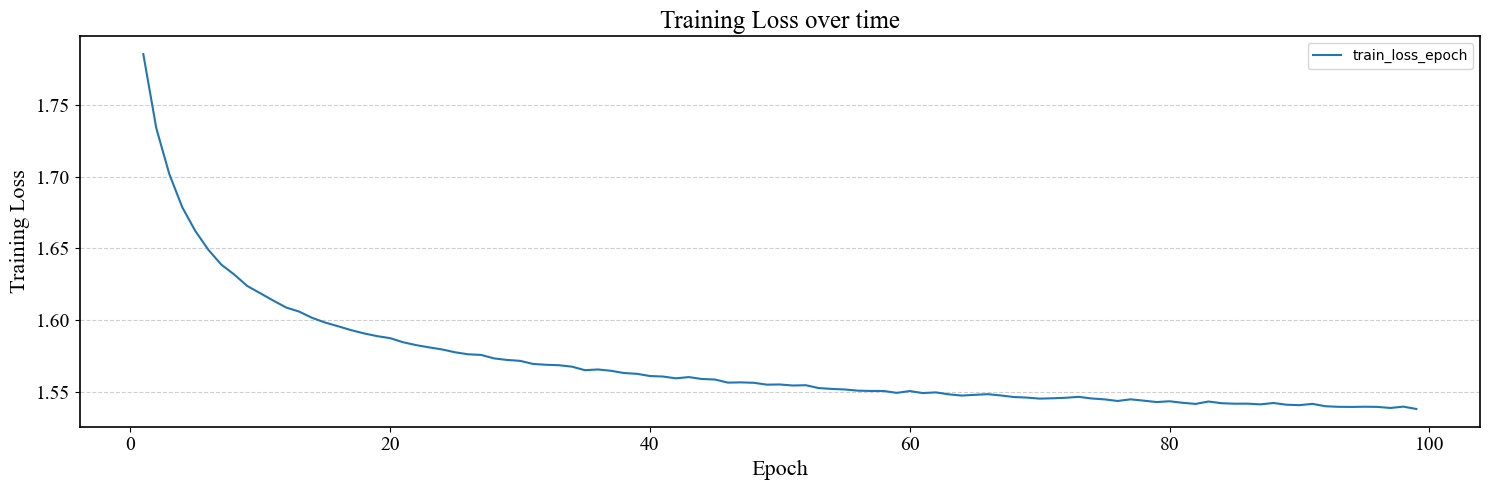

In [48]:
# Train the flow model using the fit_model utility
fit_model(
    MODEL_CONFIG["model_dir"],
    flow_model,
    train_dl,
    num_steps=MODEL_CONFIG["steps"],
    plot=True,
    gradient_clip_val=1.0,
    accelerator=str(device),
)

In [49]:
# Set the model to evaluation mode and move it to the appropriate device
flow_model.eval()
flow_model.to(device)

TimeSeriesFlowModel(
  (flows): ModuleList(
    (0-7): 8 x NiceCouplingLayer(
      (network): MLPLayer(
        (layer): Sequential(
          (0): Linear(in_features=40, out_features=40, bias=True)
          (1): ReLU()
          (2): Linear(in_features=40, out_features=40, bias=True)
        )
      )
    )
  )
)

In [50]:
# Set the random seed for reproducibility
set_random_state(ENV_CONFIG["random_state"])

# Define the number of synthetic samples to generate
num_samples = len(test_data) * DATA_CONFIG["num_eval_iterations"]

# Generate synthetic time series samples
synthetic_data = flow_model.sample(
    [num_samples, seq_len, feat_dim],
    device=device,
)

# Reshape the synthetic data to match the shape of the original test data
synthetic_data_iters = synthetic_data.cpu().numpy().reshape(-1, *test_data.shape)

Seed set to 2024


## Evaluation

Now that we've generated synthetic data, it's time to evaluate its performance.

We'll use the metrics described in the `EvaluationGenerativeModels.ipynb` notebook, so feel free to check it out if any of the metrics seem unfamiliar.

Note that the `synthetic_data_iters` array has the shape `(num_eval_iterations, test_size, sequence_len, n_feat)`. This is because we calculate the **discriminator scores** and **predictive scores** across `num_eval_iterations`. Since we generate data by sampling from the latent space, each iteration may yield different scores. Running multiple iterations helps ensure more reliable and robust scores.

In [51]:
from genai4t.evaluation.generation.visualize import (
    visualize_2d_pca,
    visualize_2d_tsne,
    visualize_time_series)
from genai4t.evaluation.generation.bp import evaluate

In [52]:
# take the first iteration and use it to compute visual metrics
first_synthetic_data = synthetic_data_iters[0]

### Visualization
Let's visualize real versus synthetic time series

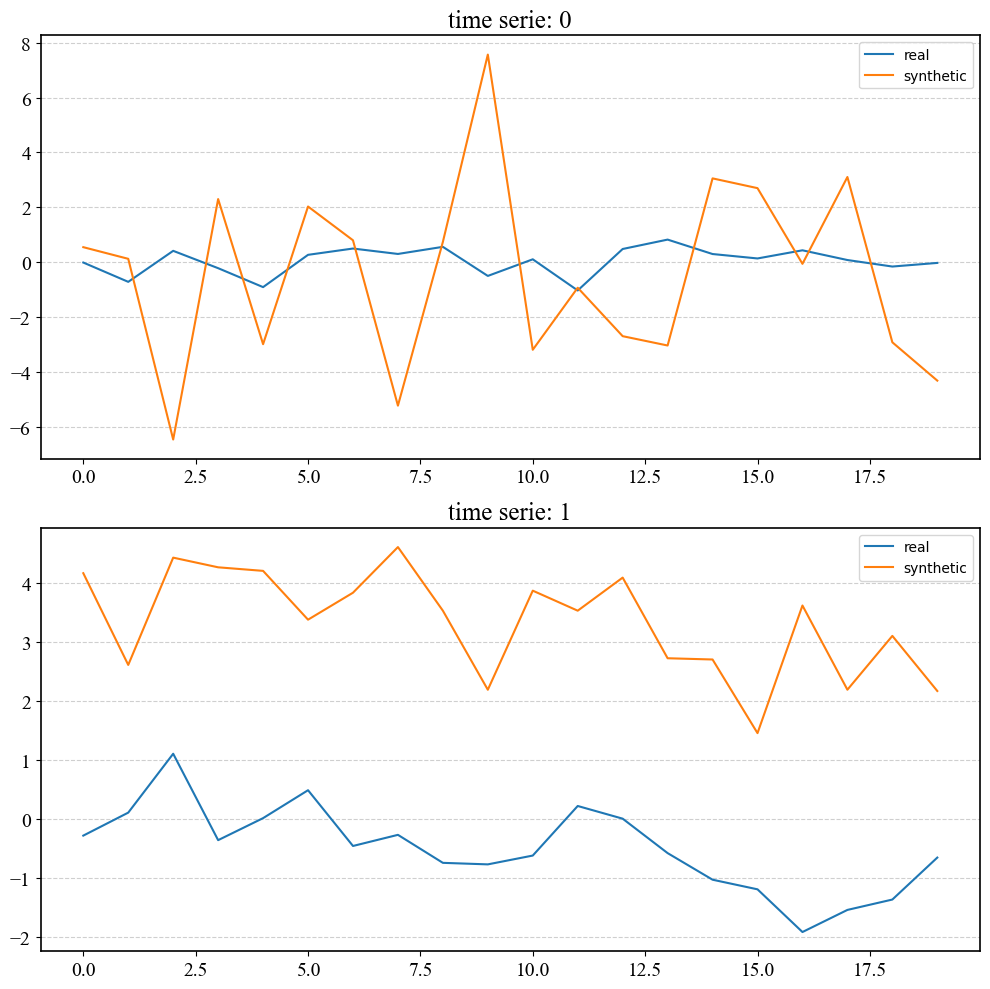

In [53]:
for i in np.random.choice(len(test_data), size=1):
    visualize_time_series(test_data[i], first_synthetic_data[i])

### Diversity

Do the generated samples cover the distribution of the real data?


To answer this question, we apply t-SNE or PCA to both the original and synthetic datasets (after flattening the temporal dimension). Here we project the data into 2-dimensional space, allowing us to visually assess how closely the distribution of the generated samples resembles that of the real data.

In [54]:
# get the first time series
test_single_series = test_data[..., 0]
synthetic_single_series = first_synthetic_data[..., 0]

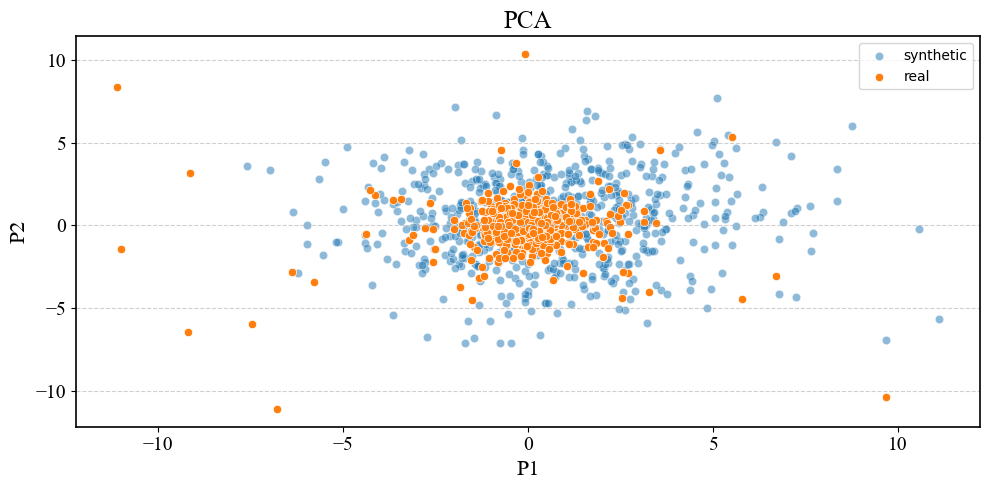

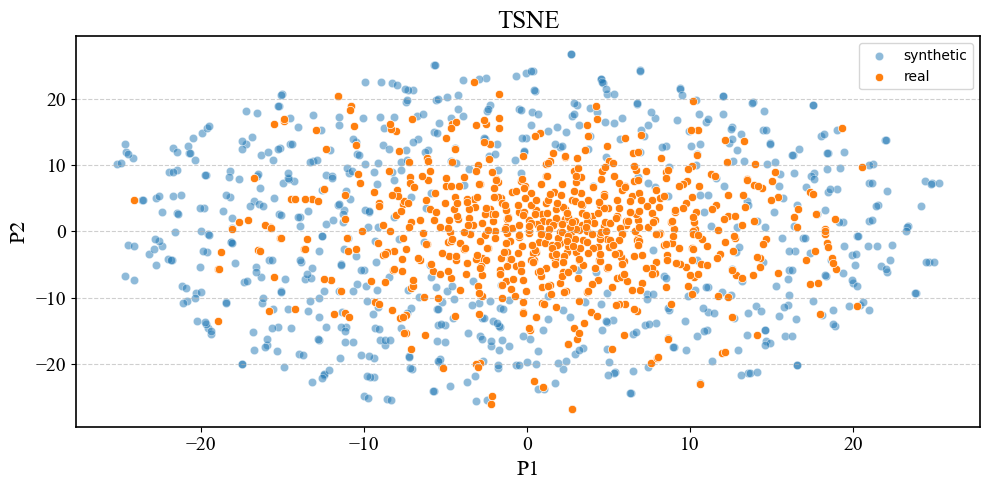

In [55]:
# Visualization of 2D PCA projection
visualize_2d_pca(test_single_series, synthetic_single_series)
# Visualization of 2D TSNE projection
visualize_2d_tsne(test_single_series, synthetic_single_series)

### Discriminative and Predictive Scores

- The **discriminative score** evaluates how well a classifier can distinguish real data from synthetic data by measuring metrics like accuracy.
  
- The **predictive score** measures how useful synthetic data is for forecasting tasks by training a model to predict the next value and comparing its performance to a model trained on real data.

For simplicity, we use a single-layer `LSTM` based architecture for both the classifier and the regressor, without any architecture search or hyperparameter tuning. More details can be found in the `EvaluationGenerativeModels.ipynb` notebook.

Below, we provide both scores

In [56]:
# compute scores
predictive_scores, discrimnative_scores = evaluate(
    test_data,
    synthetic_data_iters,
    random_state=ENV_CONFIG["random_state"],
    max_iters=DATA_CONFIG["num_eval_iterations"])

  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj_stz0yv..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwvzbfsll..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5cy3aoon..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpoyeadbub..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpk7p5pv9b..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpstx49dly..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpaxcv4rtk..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpisump78x..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpppfdpe92..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpn3ye28go..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpca9ag_5i..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpg0buiqq8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpa_jwp4x3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxim0j0sf..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpktuex_2o..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9clqqnl9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp5ehwh_h9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp25cbd8vg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmptnrxyrgp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpfwrt7pid..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0q950l0b..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmplazevrjv..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpd9tf41dh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3crvon9b..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmps1ck25kx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpw1amt2y7..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpayf5j0lp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpfccxq10i..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpek28ws2j..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp0bwmef6m..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpl12q0g9n..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpcgd4amq2..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj80bcyut..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpvj1wfdzy..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpcl7gqzu4..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpujj7j3oa..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp8f3yfff8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwgu96pxf..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpuu2ca8hn..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpxi6csd63..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpi0r5dcmo..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmppncwf9hd..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpqjbbjinu..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpmu3zfwhn..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp67aew9tv..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpttlnx_9w..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmptqp9dpg0..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpc93i51d3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpwd1_r3ph..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name | Type    | Params | Mode 
-----------------------------------------
0 | rnn  | LSTM    | 2.7 K  | train
1 | mlp  | Linear  | 50     | train
2 | _mse | MSELoss | 0      | train
-----------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/U

total_n_params: 2738
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdw0fvjal..


`Trainer.fit` stopped: `max_steps=1000` reached.


  0%|          | 0/50 [00:00<?, ?it/s]

Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottle

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnjvuycyq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpha4wfli6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj20qoq2a..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3qxzy8c5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpeu4diagi..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpm678u5wl..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpww41pvsg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpaxihgamq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpk3agmzn6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpn23dy9q8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpf4qko9o_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp72osfefa..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp66hslvmn..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmptwu8earj..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp7h9xeseu..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnr1naez8..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp02d1kde3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpg_jxazb4..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp9_v4p6zz..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpi51af7p5..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj2p2jm9t..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2j0hc3eq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp11o6oqsa..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpgw0csavg..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpgtoez0kn..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp__ubsx76..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpd18gfyai..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp1f0gc19k..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpghot73zj..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpynabdpo3..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2bk2apx9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpe891eaon..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpghwdplv6..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpfd5rebqh..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp974rtlh1..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2iswoox9..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp6ddi5hjq..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpab1kbsya..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpnhidw0ps..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp_wuno6qx..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpj7oqydp_..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpm1t3btqi..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpkqqauwz2..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp3jk_r5jp..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpcvshu9zu..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpzwuc_02e..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpsjrta29t..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmp2ons3r36..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmptxfckpew..


`Trainer.fit` stopped: `max_steps=1000` reached.
Seed set to 2024
Seed set to 2024
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type              | Params | Mode 
---------------------------------------------------
0 | rnn  | LSTM              | 2.7 K  | train
1 | mlp  | Linear            | 25     | train
2 | _bce | BCEWithLogitsLoss | 0      | train
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/Users/Shared/genai-for-trading-and-am/.venv_genai4t/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader'

total_n_params: 2713
deleting /var/folders/ck/llrrchs56758059wg3rz32p80000gn/T/tmpdbks98mq..


`Trainer.fit` stopped: `max_steps=1000` reached.


In [57]:
# Display the discriminative scores 
discrimnative_scores

,count,mean,std,min,25%,50%,75%,max
auc,50.0,0.976275,0.004484,0.964774,0.973580,0.977010,0.979561,0.983759
precision,50.0,0.956633,0.017034,0.926471,0.941444,0.960627,0.968000,0.992000
recall,50.0,0.913630,0.015085,0.888889,0.903704,0.911111,0.925926,0.948148
f1,50.0,0.934471,0.009966,0.916031,0.927757,0.932836,0.939394,0.958801
acc,50.0,0.935926,0.009820,0.918519,0.929630,0.933333,0.940741,0.959259


In [58]:
# Display the predictive scores 
predictive_scores

,count,mean,std,min,25%,50%,75%,max
MSE,50.0,0.909548,0.083760,0.754540,0.857523,0.885680,0.944846,1.197054
MAE,50.0,0.650646,0.036591,0.592827,0.625419,0.644635,0.662068,0.778298
MAPE,50.0,257.445231,108.372283,143.420541,194.866410,228.044069,274.976945,688.584805
